## Sources
* Data: https://www.ntia.doc.gov/page/download-digital-nation-datasets
* Map (useful for checks!): https://www.ntia.doc.gov/data/digital-nation-data-explorer#sel=internetAtHome&disp=map
* Docs: https://www.ntia.doc.gov/files/ntia/publications/november-2019-techdocs.pdf
* Universes: https://www.ntia.doc.gov/files/ntia/data_central_downloads/code/create-ntia-tables-stata.zip

#### Useful variables:

peinhome, peinwork, pemphone, pemphone, hemobdat, hehomte1, hefaminc, pesex, prtage, peeduca, ptdtrace, prdthsp, prnmchld, gestfips

### Which weights?

For the weights, the 2019 sample documentation suggests `PWSSWGT` and `HWHHWGT` by default, and `PWPRMWGT` for the personal questions.  Let's just check this.

In [1]:
cps_test = pd.read_csv("../data/nov19-cps.csv.gz")

# Californian people...
ca_people = cps_test.query("(gestfips == 6) & (prtage >= 3) & (prpertyp != 3)")

ca_people.query("peinhome == 1").pwprmwgt.sum() / ca_people.pwprmwgt.sum(), \
ca_people.query("peinhome == 1").pwsswgt.sum()  / ca_people.pwsswgt.sum()

(0.9328654188139469, 0.7235029866408134)

If we exampine the [NTIA site](https://www.ntia.doc.gov/data/digital-nation-data-explorer#sel=homeInternetUser&disp=map), the number for California in 2019 is 72.4%.  So `pwsswgt` is right in this case -- it is not strictly within the used services category (email, texts, social, video, etc.).  Pay attention to exactly what it takes to reproduce the results on the official site.

### The issue with San Francisco.

Now let's check in on CA and SF households.  We will contrast the calculated values with the official ones, and California generally with SF only.

In [2]:
cps_test = pd.read_csv("../data/nov19-cps.csv.gz")

# Householders
cps_test["isHouseholder"] = (cps_test.perrp > 0) & (cps_test.perrp < 3) & \
                            (cps_test.hrhtype > 0) & (cps_test.hrhtype < 9)

# Households in California, and those in SF county/city.
ca_households = cps_test.query("(gestfips == 6) & isHouseholder")
sf_households = ca_households.query("gtco == 75")

# Get the "official" estimate and compare to our calculted quantity for CA, 
#   and then SF (no official available)
ca_ntia_official = 0.799
ca_internet = ca_households.query("heinhome == 1").hwhhwgt.sum() / ca_households.hwhhwgt.sum()
sf_internet = sf_households.query("heinhome == 1").hwhhwgt.sum() / sf_households.hwhhwgt.sum()

ca_ntia_official, ca_internet, sf_internet

(0.799, 0.7992982448757221, 0.6540205571069156)

Are the errors just enormous??

In [3]:
hh               = sf_households.filter(regex = "hhwgt[1-9]\d*", axis = 1).sum()
hh_with_internet = sf_households.query("heinhome == 1").filter(regex = "hhwgt[1-9]\d*", axis = 1).sum()

sf_internet_reps = hh_with_internet / hh

np.sqrt((4 / 160) * ((sf_internet_reps - sf_internet)**2).sum())

0.04973236508815024

So I exactly reproduce the "correct" answer, but SF county shows up as quite significantly lower internet use at home than the rest of CA.

This simply does not feel correct to me.

### Constructed variables.

For reference, see the stata code by Rafi Goldberg, <rgoldberg@ntia.doc.gov>

In [4]:
cps = pd.read_csv("../data/nov19-cps.csv.gz")
#cps.query("pwsswgt > 0")

# We can get these later for standard errors...
# cps = cps.filter(regex = "^((?!wgt[0-9]).)*$", axis = 1)

## Demographics 
ed_map = {-1 : "", 31 : "No Diploma", 32 : "No Diploma", 33 : "No Diploma", 34 : "No Diploma",
          35 : "No Diploma", 36 : "No Diploma", 37 : "No Diploma", 38 : "No Diploma",
          39 : "High School", 40 : "Some College or Associates", 41 : "Some College or Associates", 42 : "Some College or Associates",
          43 : "College or Higher", 44 : "College or Higher", 45 : "College or Higher", 46 : "College or Higher"}

cps["education"] = cps.peeduca.replace(ed_map)

## Construct all the universe, following their cuts.
cps["isPerson"]      = (cps.prtage >= 3) & (cps.prpertyp != 3)
cps["isHouseholder"] = (cps.perrp > 0) & (cps.perrp < 3) & (cps.hrhtype > 0) & (cps.hrhtype < 9)
cps["isAdult"]       = cps.isPerson & (cps.prtage >= 15)
cps["isRespondent"]  = cps.puelgflg == 20

cps["P_at_home"]     = np.where(cps.isPerson, cps.peinhome == 1, np.nan)
cps["P_at_work"]     = np.where(cps.isPerson, cps.peinwork == 1, np.nan)
cps["P_at_school"]   = np.where(cps.isPerson, cps.peinschl == 1, np.nan)
cps["P_anywhere"]    = np.where(cps.isPerson, 
                                (cps.peinhome == 1) | (cps.peinwork == 1) | (cps.peinschl == 1) | \
                                (cps.peincafe == 1) | (cps.peintrav == 1) | (cps.peinlico == 1) | \
                                (cps.peinelho == 1) | (cps.peinothr == 1), 
                                np.nan)

cps["P_mobdat"]      = np.where(cps.isPerson, cps.hemobdat == 1, np.nan)

cps["P_computer"]    = np.where(cps.isPerson, (cps.pelaptop == 1) | (cps.pedesktp == 1), np.nan)
cps["P_smartphone"]  = np.where(cps.isPerson, cps.pemphone == 1, np.nan)

cps["P_email"]       = np.where(cps.isPerson, cps.peemail == 1, np.nan)
cps["P_text"]        = np.where(cps.isPerson, cps.petextim == 1, np.nan)
cps["P_social"]      = np.where(cps.isPerson, cps.pesocial == 1, np.nan)
cps["P_video"]       = np.where(cps.isPerson, cps.pevideo == 1, np.nan)
cps["P_services"]    = np.where(cps.isPerson, cps.peusesvc == 1, np.nan)
cps["P_confcall"]    = np.where(cps.isPerson, cps.peconfer == 1, np.nan)
cps["P_remote"]      = np.where(cps.isPerson, cps.petelewk == 1, np.nan)
cps["P_financ"]      = np.where(cps.isPerson, cps.pefinanc == 1, np.nan)


cps["H_at_home"]     = np.where(cps.isHouseholder, cps.heinhome == 1, np.nan)
cps["H_anywhere"]    = np.where(cps.isHouseholder, 
                                (cps.heinhome == 1) | (cps.heinwork == 1) | (cps.heinschl == 1) | \
                                (cps.heincafe == 1) | (cps.heintrav == 1) | (cps.heinlico == 1) | \
                                (cps.heinelho == 1) | (cps.heinothr == 1), 
                                np.nan)

# Reaons for non-use.
cps["H_nonuse_cost"] = np.where(cps.isHouseholder, cps.heprinoh.isin([2, 3]), np.nan)
cps["H_nonuse_no_interest"] = np.where(cps.isHouseholder, cps.heprinoh == 1, np.nan)
cps["H_nonuse_not_available"] = np.where(cps.isHouseholder, cps.heprinoh == 5, np.nan)

cps["H_smartphone"]  = cps.hemphone == 1
cps["H_computer"]    = (cps.helaptop == 1) | (cps.hedesktp == 1)

## NTIA constructs these as high speed conditional on internet, 
##   which I think is less useful than the non-conditional ACS construction, 
##   but we can do this to get their numbers.
HIGH_SPEED_CONDITIONAL = False
if HIGH_SPEED_CONDITIONAL:
    cps["H_highsp"] = np.where(cps.isHouseholder & (cps.H_anywhere == True), cps.hehomte1 == 1, np.nan)
    cps["H_mobdat"] = np.where(cps.isHouseholder & (cps.H_at_home  == True), cps.hemobdat == 1, np.nan)
else:
    cps["H_highsp"] = np.where(cps.isHouseholder, cps.hehomte1 == 1, np.nan)
    cps["H_mobdat"] = np.where(cps.isHouseholder, cps.hemobdat == 1, np.nan)

In [5]:
def get_prop(selection, universe, weight):
    
    num = cps.query(f"({selection}) & ({universe})")[weight].sum()
    den = cps.query(f"({universe})")[weight].sum()
    
    return num / den

get_prop("P_email == 1", "prtage >= 15", "pwprmwgt")

0.902661900491942

How many people are in the sample?

In [6]:
(cps_test.pwsswgt > 0).sum()

117674

### Nationwide Trends

### Lots of contortions to get Census places.

Start with states, so we can check against "official" sources.

In [7]:
import requests

resp = requests.get("https://api.census.gov/data/2019/acs/acs5/profile?get=NAME&for=state:*")
fips = {int(v[1]) : v[0] for v in resp.json()[1:]}

cps["state"] = cps.gestfips.replace(fips)

Population counts look right.

In [8]:
cps.groupby("state").pwsswgt.sum().loc[["Illinois", "California", "Pennsylvania"]] / 1e6

state
Illinois        12.497291
California      39.251506
Pennsylvania    12.622756
Name: pwsswgt, dtype: float64

### Construct city and CBSA populations.

In [9]:
cities = ["new_york", "los_angeles", "chicago", "houston", "phoenix",
          "philadelphia", "san_antonio", "san_diego", "dallas",
          "san_jose", "austin", "jacksonville", "san_francisco", "columbus",
          "fort_worth", "indianapolis", "charlotte", "seattle", "denver", "washington"]

city_dict = { # state, cbsa, city #
  "new_york"     : {"gestfips" : 36, "gtcbsa" : 35620, "gtcbsast" : 1, "gtindvpc" : 1}, 
  "los_angeles"  : {"gestfips" :  6, "gtcbsa" : 31080, "gtcbsast" : 1, "gtindvpc" : 1, "gtco" :  37}, 
  "chicago"      : {"gestfips" : 17, "gtcbsa" : 16980, "gtcbsast" : 1, "gtindvpc" : 1}, 
  "houston"      : {"gestfips" : 48, "gtcbsa" : 26420, "gtcbsast" : 1, "gtindvpc" : 1}, 
  "phoenix"      : {"gestfips" :  4, "gtcbsa" : 38060, "gtcbsast" : 1, "gtindvpc" : 1},
  "philadelphia" : {"gestfips" : 42, "gtcbsa" : 37980, "gtcbsast" : 1, "gtindvpc" : 0, "gtco" : 101},
  "san_antonio"  : {"gestfips" : 48, "gtcbsa" : 41700, "gtcbsast" : 1, "gtindvpc" : 0}, 
  "san_diego"    : {"gestfips" :  6, "gtcbsa" : 41740, "gtcbsast" : 1, "gtindvpc" : 1}, 
  "dallas"       : {"gestfips" : 48, "gtcbsa" : 19100, "gtcbsast" : 1, "gtindvpc" : 1},
  "san_jose"     : {"gestfips" :  6, "gtcbsa" : 41940, "gtcbsast" : 1, "gtindvpc" : 1}, 
  "austin"       : {"gestfips" : 48, "gtcbsa" : 12420, "gtcbsast" : 1, "gtindvpc" : 0}, 
  "jacksonville" : {"gestfips" : 12, "gtcbsa" : 27260, "gtcbsast" : 1, "gtindvpc" : 0}, 
  "san_francisco": {"gestfips" :  6, "gtcbsa" : 41860, "gtcbsast" : 1, "gtindvpc" : 1, "gtco" :  75}, # SF county
  "columbus"     : {"gestfips" : 39, "gtcbsa" : 18140, "gtcbsast" : 1, "gtindvpc" : 0},
  "fort_worth"   : {"gestfips" : 48, "gtcbsa" : 19100, "gtcbsast" : 1, "gtindvpc" : 2}, 
  "indianapolis" : {"gestfips" : 18, "gtcbsa" : 26900, "gtcbsast" : 1, "gtindvpc" : 1}, 
  "charlotte"    : {"gestfips" : 37, "gtcbsa" : 16740, "gtcbsast" : 1, "gtindvpc" : 1}, 
  "seattle"      : {"gestfips" : 53, "gtcbsa" : 42660, "gtcbsast" : 1, "gtindvpc" : 1}, 
  "denver"       : {"gestfips" :  8, "gtcbsa" : 19740, "gtcbsast" : 1, "gtindvpc" : 1}, 
  "washington"   : {"gestfips" : 11, "gtcbsa" : 47900, "gtcbsast" : 1, "gtindvpc" : 1}
}

cps["city"] = ""
for city, vals in city_dict.items():
    
    query = " & ".join(["({} == {:})".format(k, v)
                        for k, v in vals.items()])
    
    cps.loc[cps.query(query).index, "city"] = city
    
cps_city = cps[cps.city != ""].copy()

In [10]:
cps[["city", "gestfips", "gtcbsa", "gtcsa", "gtmetsta", "gtcbsast", "gtindvpc", "gtco"]]\
   .query("(gestfips == 6) & (gtco == 75)").drop_duplicates().sort_values("city")

,city,gestfips,gtcbsa,gtcsa,gtmetsta,gtcbsast,gtindvpc,gtco
6460,san_francisco,6,41860,488,1,1,1,75


In [11]:
cbsa = ["new_york", "los_angeles", "chicago", "dallas-fort_worth", "houston", 
        "philadelphia", "washington", "miami", "atlanta", "boston", 
        "san_francisco", "riverside", "phoenix", "detroit", "seattle", 
        "minneapolis", "san_diego", "tampa", "st_louis", "denver"]

cbsa_dict = {
    35620 : "new_york", 31080 : "los_angeles", 16980 : "chicago", 19100 : "dallas-fort_worth", 26420 : "houston", 
    37980 : "philadelphia", 47900 : "washington", 33100 : "miami", 12060 : "atlanta", 14460 : "boston", 
    41860 : "san_francisco", 40140 : "riverside", 38060 : "phoenix", 19820 : "detroit", 42660 : "seattle", 
    33460 : "minneapolis", 41740 : "san_diego", 45300 : "tampa", 41180 : "st_louis", 19740 : "denver"
}

cps["cbsa"] = ""
cps.loc[cps.query("gtcbsa in @cbsa_dict").index, "cbsa"] = \
   cps.query("gtcbsa in @cbsa_dict").gtcbsa.replace(cbsa_dict)

cps_cbsa = cps[cps.cbsa != ""].copy()

In [12]:
# cps[["city", "gestfips", "gtcbsa", "gtcsa", "gtmetsta", "gtcbsast", "gtindvpc", "gtco"]]\
#    .query("city != ''").drop_duplicates().sort_values("city")

These populations seem about right... Washington DC is _way_ oversampled... weights are **necessary**.  In particular, San Francisco, where I had issues below is about 10% off of its "nominal" population (800k instead of 880k).

In [13]:
counts = cps_city.groupby("city").agg({"pwsswgt" : ["sum", "count"]})
counts.columns = ["cps_population", "N"]
city_populations = counts.sort_values(by = "cps_population", ascending = False)
city_populations

,cps_population,N
city,,
new_york,8.278783e+06,2281
los_angeles,4.074095e+06,1215
chicago,2.496310e+06,748
houston,2.191824e+06,591
san_antonio,1.851952e+06,497
philadelphia,1.645956e+06,418
phoenix,1.523442e+06,474
san_diego,1.292693e+06,374
fort_worth,1.138746e+06,272


(200,)

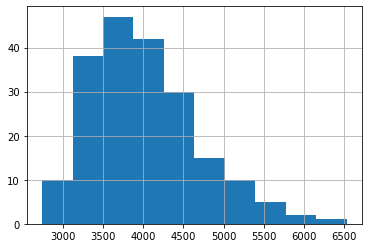

In [14]:
cps_city[(cps_city.city == "san_francisco") & (cps_city.pwsswgt > 0)].pwsswgt.hist()
cps_city[(cps_city.city == "san_francisco") & (cps_city.pwsswgt > 0)].pwsswgt.shape

### Construct the basic variables.

If the `HIGH_SPEED_CONDITIONAL` is true, this will give the NTIA results for states.

Internet in home.

In [15]:
def weighted_mean(G, w): return G._get_numeric_data().multiply(G[w],  axis=0).sum()/G[w].sum()

def access(df, grouper, HH = True, person = True):
    
    out_data = []
    
    if HH:
        
        hwss_vars =  df.query("isHouseholder").groupby(grouper).apply(weighted_mean, w = "hwhhwgt")\
                       [["H_at_home", "H_mobdat", "H_highsp"]]

        hwss_vars_use =  df.query("isHouseholder & (H_at_home == False)")\
                           .groupby(grouper).apply(weighted_mean, w = "hwhhwgt")\
                           [["H_nonuse_cost", "H_nonuse_no_interest", "H_nonuse_not_available"]]
        
        out_data.extend([hwss_vars, hwss_vars_use])

    if person:
        
        counts = df.query("isPerson").groupby(grouper).agg({"pwsswgt" : ["sum", "count"]})
        counts.columns = ["cps_population", "N"]
        
        pwss_vars =  df.query("isPerson").groupby(grouper).apply(weighted_mean, w = "pwsswgt")\
                       [["P_anywhere", "P_at_home", "P_at_work", "P_smartphone", "P_computer"]] 

        pwpr_vars =  df.query("isRespondent").groupby(grouper).apply(weighted_mean, w = "pwprmwgt")\
                       [["P_email", "P_text", "P_confcall", "P_remote", 
                         "P_social", "P_video", "P_services", "P_financ"]]
        
        out_data.extend([counts, pwss_vars, pwpr_vars])
        
    complete = pd.concat(out_data, axis = 1).round(3)
        
    complete.index = complete.index.str.replace("_", " ").str.title()

    return complete.round(3)
    

### For comparison -- NTIA/Rafi Goldberg's results.

In [16]:
ntia_official = pd.read_csv("../data/ntia-analyze-table_2020-05-15.csv")
ntia_official.query("dataset == 'Nov 2019'", inplace = True)
ntia_official.drop("dataset", axis = 1, inplace = True)
ntia_official.set_index("variable", inplace = True)
ntia_official = ntia_official.transpose()

### Demographics
Example is education level.

In [17]:
access(cps.query("prtage >= 15"), "education", HH = False)

,cps_population,N,P_anywhere,P_at_home,P_at_work,P_smartphone,P_computer,P_email,P_text,P_confcall,P_remote,P_social,P_video,P_services,P_financ
education,,,,,,,,,,,,,,,
College Or Higher,8.480815e+07,31130,0.888,0.856,0.574,0.838,0.800,0.971,0.948,0.614,0.400,0.752,0.798,0.496,0.840
High School,7.209468e+07,27008,0.745,0.684,0.249,0.681,0.458,0.830,0.892,0.374,0.114,0.699,0.664,0.197,0.576
No Diploma,3.710227e+07,12954,0.689,0.623,0.089,0.634,0.394,0.733,0.879,0.433,0.049,0.719,0.727,0.133,0.344
Some College Or Associates,7.017797e+07,25835,0.850,0.807,0.393,0.797,0.690,0.938,0.932,0.515,0.206,0.758,0.748,0.333,0.751


In [18]:
ntia_official.loc[ntia_official.index.str.contains("^ed.*Prop$"), 
                  ["internetUser", "homeInternetUser"]]

variable,internetUser,homeInternetUser
edNoDiplomaProp,0.689243,0.623134
edHSGradProp,0.745495,0.683753
edSomeCollegeProp,0.849628,0.807262
edCollegeGradProp,0.888044,0.856397


Looks good.

### Full US

In [19]:
cps["all"] = "Prop."
adult_access = access(cps.query("prtage >= 18"), "all", HH = False).filter(regex = "^P_.*", axis = 1).T

In [20]:
import re

univ = {"P_anywhere" : "Adults", "P_at_home" : "Adults", "P_at_work" : "Adults",
        "P_computer" : "Adults", "P_smartphone" : "Adults", 
        "P_email" : "Internet Users", "P_text" : "Internet Users", "P_confcall" : "Internet Users", 
        "P_remote" : "Internet Users", "P_social" : "Internet Users", "P_video" : "Internet Users", 
        "P_services" : "Internet Users", "P_financ" : "Internet Users", }

labels = {"P_anywhere" : "Internet Anywhere", 
          "P_at_home" : "Internet at Home", 
          "P_at_work" : "Internet at Work",
          "P_computer" : "Desktop or Laptop", 
          "P_smartphone" : "Smartphone", 
          "P_email" : "Email", "P_text" : "Texting", "P_confcall" : "Calling", 
          "P_remote" : "Remote Work", "P_social" : "Social Media", "P_video" : "Watching Videos", 
          "P_services" : "Services from Others", "P_financ" : "Financial Services", }

caption = "Proportion of US adults who use various Internet technologies and services. \label{tab:users}"

access_tex = adult_access.reset_index().round(2)
access_tex.rename(columns = {"index" : "req"}, inplace = True)
access_tex["univ"] = access_tex["req"].replace(univ)
access_tex["req"] = access_tex["req"].replace(labels)
access_tex = access_tex[["univ", "req", "Prop."]].copy()

access_tex = access_tex[["req", "Prop."]]
access_tex = access_tex.to_latex(index = False, column_format = "lc", caption = caption)

replacements = {"midrule" : "hline", "bottomrule" : "hline",
                "\\\\toprule.*\n" : "\\\\multicolumn{2}{c}{US adults who use...} \\\\\\\\ ", 
                r"( *Email)" : r"\\hline \\\\\n\\multicolumn{2}{c}{US adult Internet users who use...} \\\\ \n\\hline\n\1", 
                r" *req.*" : ""}

for k, v in replacements.items():
    access_tex = re.sub(k, v, access_tex)


with open("users.tex", "w") as o: o.write(access_tex)
    
# print(access_tex)

### States

In [21]:
state_access = access(cps, "state")
state_access.sort_values("H_highsp", inplace = True)
state_access.style.background_gradient(cmap = "viridis")

,H_at_home,H_mobdat,H_highsp,H_nonuse_cost,H_nonuse_no_interest,H_nonuse_not_available,cps_population,N,P_anywhere,P_at_home,P_at_work,P_smartphone,P_computer,P_email,P_text,P_confcall,P_remote,P_social,P_video,P_services,P_financ
state,,,,,,,,,,,,,,,,,,,,,
Mississippi,0.755000,0.695000,0.539000,0.191000,0.605000,0.070000,2820663.157000,2116,0.759000,0.688000,0.226000,0.643000,0.461000,0.824000,0.913000,0.485000,0.148000,0.775000,0.662000,0.135000,0.556000
Kentucky,0.762000,0.706000,0.582000,0.206000,0.531000,0.034000,4265226.376000,1434,0.785000,0.707000,0.304000,0.664000,0.525000,0.855000,0.928000,0.492000,0.200000,0.766000,0.754000,0.217000,0.660000
Louisiana,0.757000,0.707000,0.597000,0.186000,0.602000,0.047000,4377499.100000,2608,0.763000,0.699000,0.278000,0.668000,0.493000,0.850000,0.933000,0.529000,0.172000,0.752000,0.735000,0.225000,0.636000
Wyoming,0.762000,0.644000,0.604000,0.195000,0.560000,0.074000,549533.430000,1650,0.791000,0.731000,0.319000,0.655000,0.562000,0.889000,0.921000,0.459000,0.210000,0.730000,0.728000,0.242000,0.668000
Oklahoma,0.807000,0.770000,0.626000,0.184000,0.615000,0.041000,3707593.333000,1758,0.832000,0.766000,0.292000,0.690000,0.595000,0.863000,0.926000,0.458000,0.248000,0.777000,0.704000,0.263000,0.661000
Arkansas,0.801000,0.757000,0.627000,0.269000,0.558000,0.051000,2879321.353000,2130,0.809000,0.728000,0.297000,0.674000,0.517000,0.891000,0.934000,0.500000,0.223000,0.791000,0.727000,0.193000,0.658000
North Carolina,0.741000,0.655000,0.631000,0.225000,0.577000,0.012000,10009417.919000,2626,0.743000,0.682000,0.279000,0.640000,0.523000,0.863000,0.890000,0.440000,0.224000,0.718000,0.718000,0.248000,0.592000
Tennessee,0.758000,0.718000,0.632000,0.266000,0.556000,0.031000,6511945.825000,2264,0.762000,0.693000,0.287000,0.639000,0.572000,0.859000,0.925000,0.472000,0.215000,0.737000,0.685000,0.291000,0.632000
Georgia,0.783000,0.715000,0.632000,0.229000,0.577000,0.050000,10057306.945000,2621,0.794000,0.737000,0.299000,0.693000,0.577000,0.899000,0.932000,0.537000,0.251000,0.700000,0.716000,0.307000,0.717000


In [22]:
ntia_official.loc["CAProp", ["internetAtHome", "internetUser"]]

variable
internetAtHome    0.799298
internetUser      0.777888
Name: CAProp, dtype: object

### Get State Level Estimates from the ACS

https://api.census.gov/data/2019/acs/acs1/profile?get=NAME,DP02_0087E,DP02_0153PE&for=place

In [23]:
def get_acs_by_geog(geog):

    api_base = "https://api.census.gov/data/2019/acs/acs1/profile"
    
    resp = requests.get(f"{api_base}?get=NAME,DP02_0087E,DP02_0153PE&for={geog}:*")

    j = resp.json()
    acs_rates = pd.DataFrame(columns = j[0], data = j[1:])

    acs_rates.rename(columns = {geog : "geoid"}, inplace = True)
    acs_rates.rename(columns = {"NAME" : geog, 
                                "DP02_0087E" : "acs_population",
                                "DP02_0153PE" : "acs_broadband"},
                     inplace = True)
    
    acs_rates.query("~acs_broadband.isna()", inplace = True)

    acs_rates["geoid"] = acs_rates["geoid"].astype(int)
    acs_rates["acs_broadband"] = acs_rates["acs_broadband"].astype(float)
    acs_rates["acs_population"] = acs_rates["acs_population"].astype(int)
    
    acs_rates.set_index(geog, inplace = True)
    
    return acs_rates[["acs_population", "acs_broadband", "geoid"]]

In [24]:
acs_state = get_acs_by_geog("state")

In [25]:
acs_cps_state = state_access.join(acs_state)

acs_broadband             1.000000
P_services                0.752656
H_highsp                  0.720474
P_email                   0.713937
P_financ                  0.667406
P_computer                0.666397
P_at_work                 0.614597
P_remote                  0.591254
P_at_home                 0.560521
H_at_home                 0.539135
P_smartphone              0.485459
P_confcall                0.439268
H_mobdat                  0.433415
P_anywhere                0.430886
P_video                   0.425971
P_text                    0.221868
cps_population            0.197541
acs_population            0.195603
H_nonuse_not_available    0.136694
N                         0.086723
geoid                    -0.034241
H_nonuse_no_interest     -0.079330
H_nonuse_cost            -0.286770
P_social                 -0.300830
Name: acs_broadband, dtype: float64

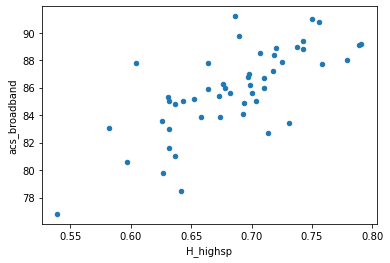

In [26]:
acs_cps_state.plot(kind = "scatter", x = "H_highsp", y = "acs_broadband")
acs_cps_state.corr().acs_broadband.sort_values(ascending = False)

### Cities

In [27]:
city_access = access(cps_city, "city")
city_access.sort_values("H_highsp", ascending = False, inplace = True)
city_access.style.background_gradient(cmap = "viridis", axis = 0)

,H_at_home,H_mobdat,H_highsp,H_nonuse_cost,H_nonuse_no_interest,H_nonuse_not_available,cps_population,N,P_anywhere,P_at_home,P_at_work,P_smartphone,P_computer,P_email,P_text,P_confcall,P_remote,P_social,P_video,P_services,P_financ
city,,,,,,,,,,,,,,,,,,,,,
San Jose,0.897000,0.853000,0.861000,0.118000,0.737000,0.145000,712351.707000,176,0.871000,0.853000,0.500000,0.800000,0.743000,0.979000,0.947000,0.686000,0.338000,0.702000,0.887000,0.554000,0.844000
Austin,0.922000,0.911000,0.826000,0.139000,0.572000,0.000000,772743.135000,191,0.928000,0.845000,0.460000,0.841000,0.746000,0.982000,0.987000,0.677000,0.390000,0.712000,0.864000,0.600000,0.842000
Washington,0.853000,0.822000,0.795000,0.253000,0.533000,0.022000,675022.827000,1560,0.873000,0.825000,0.497000,0.767000,0.712000,0.948000,0.957000,0.758000,0.536000,0.781000,0.865000,0.789000,0.870000
Dallas,0.901000,0.889000,0.788000,0.464000,0.452000,0.000000,949174.713000,218,0.843000,0.783000,0.376000,0.821000,0.527000,0.929000,0.977000,0.633000,0.309000,0.768000,0.837000,0.493000,0.730000
Seattle,0.871000,0.820000,0.783000,0.157000,0.615000,0.000000,724611.591000,192,0.918000,0.831000,0.565000,0.768000,0.720000,0.935000,0.928000,0.679000,0.434000,0.690000,0.962000,0.729000,0.893000
Denver,0.833000,0.752000,0.781000,0.273000,0.416000,0.134000,766922.591000,179,0.829000,0.777000,0.421000,0.753000,0.655000,0.975000,0.964000,0.644000,0.377000,0.838000,0.873000,0.626000,0.707000
Columbus,0.793000,0.739000,0.750000,0.549000,0.344000,0.000000,913920.005000,172,0.816000,0.778000,0.384000,0.767000,0.625000,0.927000,0.948000,0.472000,0.178000,0.760000,0.808000,0.403000,0.761000
San Diego,0.792000,0.695000,0.728000,0.237000,0.480000,0.084000,1276144.608000,327,0.831000,0.756000,0.351000,0.750000,0.660000,0.926000,0.915000,0.546000,0.353000,0.694000,0.801000,0.587000,0.793000
Charlotte,0.825000,0.756000,0.722000,0.414000,0.430000,0.000000,692284.960000,169,0.786000,0.736000,0.273000,0.719000,0.585000,0.849000,0.887000,0.488000,0.324000,0.633000,0.711000,0.346000,0.695000


The fact that SF is low still feels really weird.

In [45]:
sf = cps.query("(gestfips == 6) & (gtcbsa == 41860) & (gtcbsast == 1) & (gtco == 75) & (gtindvpc == 1)")
sf_internet = sf.query("(heinhome == 1) & isHouseholder").hwhhwgt.sum() / sf.query("isHouseholder").hwhhwgt.sum()

sf_internet

0.6540205571069156

Let's just check in on the standard errors... https://cps.ipums.org/cps/repwt.shtml#q40

In [46]:
hh               = sf.query("isHouseholder").filter(regex = "hhwgt[1-9]\d*", axis = 1).sum()
hh_with_internet = sf.query("(heinhome == 1) & isHouseholder").filter(regex = "hhwgt[1-9]\d*", axis = 1).sum()

sf_internet_reps = hh_with_internet / hh

np.sqrt((4 / 160) * ((sf_internet_reps - sf_internet)**2).sum())

0.04973236508815024

It's big -- 5% -- but since California is at 80%, it's still 3σ!!

In [30]:
acs_place = get_acs_by_geog("place")
acs_place = acs_place.sort_values("acs_population", ascending = False).head(20).copy()
acs_place.index = acs_place.index.str.replace(" city.*", "", regex = True)

In [31]:
cps_vs_acs = city_access.join(acs_place)

city
San Jose         0.697163
Dallas           0.706460
Charlotte        0.781618
Austin           0.789107
Phoenix          0.868343
San Diego        0.896262
Houston          0.905817
San Francisco    0.906625
Chicago          0.907848
New York         0.948774
Washington       0.956463
Seattle          0.961463
Jacksonville     0.970680
Los Angeles      0.996380
Philadelphia     1.011742
Columbus         1.013133
Denver           1.054608
Indianapolis     1.065808
San Antonio      1.142029
Fort Worth       1.187761
Name: pop_ratio, dtype: float64

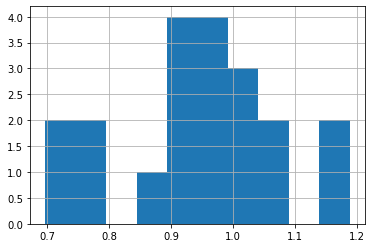

In [32]:
cps_vs_acs["pop_ratio"] = cps_vs_acs["cps_population"] / cps_vs_acs["acs_population"]
cps_vs_acs.pop_ratio.hist()
cps_vs_acs.pop_ratio.sort_values()

0.5609941970279922


,H_highsp,acs_broadband
city,,
Indianapolis,0.543,82.4
Chicago,0.600,83.6
San Francisco,0.614,89.7
Los Angeles,0.621,87.7
Houston,0.623,85.0
Philadelphia,0.638,84.2
Phoenix,0.651,84.9
San Antonio,0.667,83.1
Jacksonville,0.671,88.2


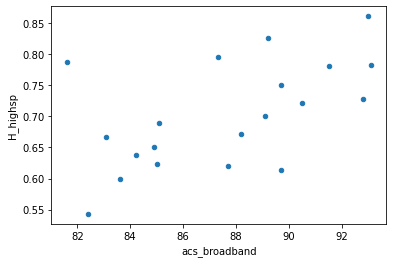

In [33]:
cps_vs_acs.plot(kind = "scatter", x = "acs_broadband", y = "H_highsp")
print(cps_vs_acs.corr()["H_highsp"]["acs_broadband"])

cps_vs_acs[["H_highsp", "acs_broadband"]].sort_values(by = "H_highsp")

### CBSA

In [34]:
cps_cbsa_agg = access(cps_cbsa, "cbsa")
cps_cbsa_agg.sort_values("H_highsp", ascending = False).style.background_gradient(cmap = "viridis", axis = 0)

,H_at_home,H_mobdat,H_highsp,H_nonuse_cost,H_nonuse_no_interest,H_nonuse_not_available,cps_population,N,P_anywhere,P_at_home,P_at_work,P_smartphone,P_computer,P_email,P_text,P_confcall,P_remote,P_social,P_video,P_services,P_financ
cbsa,,,,,,,,,,,,,,,,,,,,,
Dallas-Fort Worth,0.875000,0.839000,0.788000,0.237000,0.537000,0.067000,8025142.352000,1825,0.841000,0.766000,0.346000,0.741000,0.605000,0.933000,0.970000,0.596000,0.263000,0.778000,0.834000,0.377000,0.776000
Washington,0.850000,0.798000,0.778000,0.168000,0.496000,0.096000,5914246.172000,2852,0.817000,0.773000,0.395000,0.712000,0.652000,0.948000,0.945000,0.606000,0.377000,0.748000,0.816000,0.553000,0.827000
Denver,0.856000,0.790000,0.777000,0.215000,0.547000,0.075000,2831877.222000,694,0.855000,0.788000,0.389000,0.733000,0.653000,0.974000,0.957000,0.600000,0.373000,0.768000,0.827000,0.532000,0.750000
Tampa,0.783000,0.603000,0.746000,0.262000,0.554000,0.025000,2928313.477000,798,0.785000,0.718000,0.319000,0.659000,0.601000,0.949000,0.873000,0.475000,0.169000,0.718000,0.671000,0.286000,0.691000
Phoenix,0.838000,0.789000,0.742000,0.215000,0.566000,0.011000,4780563.807000,1310,0.823000,0.784000,0.320000,0.731000,0.626000,0.931000,0.953000,0.545000,0.288000,0.721000,0.760000,0.371000,0.784000
Minneapolis,0.875000,0.804000,0.738000,0.076000,0.563000,0.000000,3397369.718000,974,0.843000,0.812000,0.403000,0.725000,0.648000,0.953000,0.944000,0.540000,0.323000,0.778000,0.811000,0.483000,0.826000
San Francisco,0.804000,0.738000,0.734000,0.191000,0.550000,0.059000,4559477.778000,1130,0.797000,0.761000,0.375000,0.711000,0.638000,0.970000,0.950000,0.648000,0.374000,0.726000,0.857000,0.615000,0.761000
New York,0.787000,0.717000,0.731000,0.151000,0.627000,0.007000,19249568.003000,4724,0.779000,0.729000,0.312000,0.679000,0.577000,0.904000,0.926000,0.535000,0.259000,0.719000,0.713000,0.409000,0.646000
Seattle,0.823000,0.773000,0.727000,0.080000,0.575000,0.075000,4012495.755000,1113,0.819000,0.768000,0.370000,0.689000,0.620000,0.953000,0.910000,0.513000,0.268000,0.654000,0.821000,0.440000,0.815000


In [35]:
cbsa_dict = {
    35620 : "New York", 31080 : "Los Angeles", 16980 : "Chicago", 19100 : "Dallas-Fort Worth", 26420 : "Houston", 
    37980 : "Philadelphia", 47900 : "Washington", 33100 : "Miami", 12060 : "Atlanta", 14460 : "Boston", 
    41860 : "San Francisco", 40140 : "Riverside", 38060 : "Phoenix", 19820 : "Detroit", 42660 : "Seattle", 
    33460 : "Minneapolis", 41740 : "San Diego", 45300 : "Tampa", 41180 : "St Louis", 19740 : "Denver"
}

acs_cbsa = get_acs_by_geog("metropolitan statistical area/micropolitan statistical area")

acs_cbsa.index = acs_cbsa.geoid.replace(cbsa_dict)
acs_cbsa = acs_cbsa.sort_values("acs_population", ascending = False).head(20).copy()

In [36]:
cps_acs_cbsa = cps_cbsa_agg.join(acs_cbsa)

<AxesSubplot:>

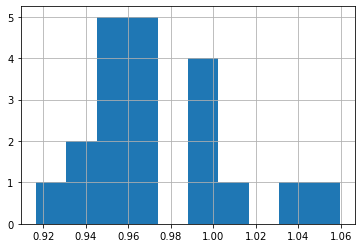

In [37]:
cps_acs_cbsa["pop_ratio"] = cps_acs_cbsa["cps_population"] / cps_acs_cbsa["acs_population"]
cps_acs_cbsa.pop_ratio.hist()

<AxesSubplot:xlabel='acs_broadband', ylabel='H_highsp'>

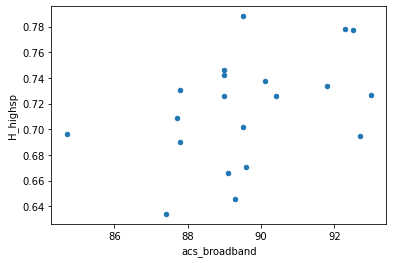

In [38]:
cps_acs_cbsa[["H_highsp", "acs_broadband"]].sort_values(by = "acs_broadband")
cps_acs_cbsa.plot(kind = "scatter", x = "acs_broadband", y = "H_highsp")

In [39]:
cps_acs_cbsa.corr().acs_broadband.sort_values(ascending = False)

acs_broadband             1.000000
H_nonuse_not_available    0.817322
P_video                   0.758293
P_services                0.671668
P_remote                  0.607726
P_email                   0.590693
P_financ                  0.577321
P_at_work                 0.561721
P_confcall                0.487396
P_anywhere                0.476369
P_at_home                 0.463248
P_computer                0.463044
P_smartphone              0.450642
H_at_home                 0.416619
H_highsp                  0.411669
H_mobdat                  0.298020
geoid                     0.218269
P_text                    0.157563
P_social                  0.076598
H_nonuse_cost             0.045399
N                        -0.212578
pop_ratio                -0.259661
acs_population           -0.321776
cps_population           -0.333469
H_nonuse_no_interest     -0.675195
Name: acs_broadband, dtype: float64

<AxesSubplot:xlabel='acs_broadband', ylabel='H_highsp'>

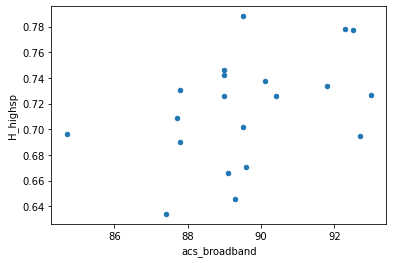

In [40]:
cps_acs_cbsa.plot(kind = "scatter", x = "acs_broadband", y = "H_highsp")

### Reasons for non-use.

In [41]:
why_no_net = {
  1  : "Don't need it or not interested",
  2  : "Can't afford it",
  3  : "Not worth the cost",
  4  : "Can use it elsewhere",
  5  : "Not available in area",
  6  : "No device",
  7  : "Privacy or security concerns",
  8  : "Safety concerns",
  9  : "Moving",
  10 : "Other",
  -1 : "NA"
}

cps["why_no_net"] = cps.heprinoh.replace(why_no_net)

(cps.query("heprinoh > 0").groupby("why_no_net").hwhhwgt.sum().sort_values(ascending = False) / 1e6).round(2)

why_no_net
Don't need it or not interested    30.09
Can't afford it                     9.14
Other                               4.74
Not available in area               2.03
Can use it elsewhere                1.79
No device                           1.36
Not worth the cost                  1.31
Privacy or security concerns        0.79
Moving                              0.20
Safety concerns                     0.19
Name: hwhhwgt, dtype: float64